In [120]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import time

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.base import TransformerMixin

import regex as re

random_state = 11

In [100]:
master = pd.read_csv('~/downloads/new_beds.csv')

In [101]:
master = master.drop(columns = 'Unnamed: 0')

In [102]:
master.head()

,county_x,state,id,population,estimate!!race!!total population!!one race,estimate!!race!!total population!!two or more races,estimate!!race!!total population!!one race.1,estimate!!race!!total population!!one race!!white,estimate!!race!!total population!!one race!!black or african american,estimate!!race!!total population!!one race!!american indian and alaska native,...,"cert nurse midwvs,ft oth emptyp_y",nursing facilities total beds,nurse practitioners_y,"advpractnurs midwve,male w/npi",st_num,countyfips,beds,case_per_pop,beds_per_pop,beds_per_case
0,autauga county,AL,1001,55200,54170,1030,54170,42437,10565,159,...,0.0,0.0,0.0,0.0,1,1001,85.0,0.001214,0.001540,1.268657
1,baldwin county,AL,1003,208107,204535,3572,204535,179526,19764,1522,...,0.0,0.0,0.0,0.0,1,1003,386.0,0.000999,0.001855,1.855769
2,barbour county,AL,1005,25782,25429,353,25429,12216,12266,72,...,0.0,0.0,0.0,0.0,1,1005,74.0,0.002056,0.002870,1.396226
3,bibb county,AL,1007,22527,22340,187,22340,17268,5018,8,...,0.0,0.0,0.0,0.0,1,1007,35.0,0.001953,0.001554,0.795455
4,blount county,AL,1009,57645,56710,935,56710,55054,862,141,...,0.0,0.0,0.0,0.0,1,1009,25.0,0.000763,0.000434,0.568182


(array([3.051e+03, 4.200e+01, 1.100e+01, 1.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([0.        , 0.01415439, 0.02830879, 0.04246318, 0.05661757,
        0.07077196, 0.08492636, 0.09908075, 0.11323514, 0.12738953,
        0.14154393]),
 <a list of 10 Patch objects>)

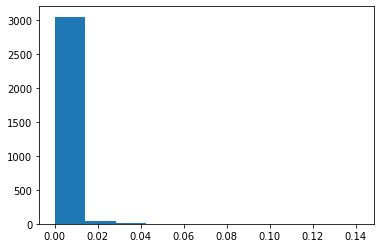

In [103]:
plt.hist(master['case_per_pop'])

In [104]:
master['case_per_pop'].describe()

count    3108.000000
mean        0.001994
std         0.004738
min         0.000000
25%         0.000333
50%         0.000784
75%         0.001943
max         0.141544
Name: case_per_pop, dtype: float64

In [105]:
.95/2/2

0.2375

In [106]:
master.shape[0] * 0.2375

738.15

In [107]:
master.shape[0] - 739

2369

In [108]:
master.shape[0] * .1

310.8

In [109]:
above_std_1 = master.sort_values(by = 'case_per_pop', ascending = False).head(739)

In [110]:
above_std_1['case_per_pop'] = ((above_std_1['case_per_pop'].values *0) +1).astype(int)

In [111]:
below = master.sort_values(by = 'case_per_pop', ascending = False).tail(2369)

In [112]:
below['case_per_pop'] = ((below['case_per_pop'].values *0)).astype(int)

In [113]:
master['case_per_pop'] = pd.concat([above_std_1['case_per_pop'],below['case_per_pop']])
master.head()

,county_x,state,id,population,estimate!!race!!total population!!one race,estimate!!race!!total population!!two or more races,estimate!!race!!total population!!one race.1,estimate!!race!!total population!!one race!!white,estimate!!race!!total population!!one race!!black or african american,estimate!!race!!total population!!one race!!american indian and alaska native,...,"cert nurse midwvs,ft oth emptyp_y",nursing facilities total beds,nurse practitioners_y,"advpractnurs midwve,male w/npi",st_num,countyfips,beds,case_per_pop,beds_per_pop,beds_per_case
0,autauga county,AL,1001,55200,54170,1030,54170,42437,10565,159,...,0.0,0.0,0.0,0.0,1,1001,85.0,0,0.001540,1.268657
1,baldwin county,AL,1003,208107,204535,3572,204535,179526,19764,1522,...,0.0,0.0,0.0,0.0,1,1003,386.0,0,0.001855,1.855769
2,barbour county,AL,1005,25782,25429,353,25429,12216,12266,72,...,0.0,0.0,0.0,0.0,1,1005,74.0,1,0.002870,1.396226
3,bibb county,AL,1007,22527,22340,187,22340,17268,5018,8,...,0.0,0.0,0.0,0.0,1,1007,35.0,0,0.001554,0.795455
4,blount county,AL,1009,57645,56710,935,56710,55054,862,141,...,0.0,0.0,0.0,0.0,1,1009,25.0,0,0.000434,0.568182


In [114]:
master.head()

,county_x,state,id,population,estimate!!race!!total population!!one race,estimate!!race!!total population!!two or more races,estimate!!race!!total population!!one race.1,estimate!!race!!total population!!one race!!white,estimate!!race!!total population!!one race!!black or african american,estimate!!race!!total population!!one race!!american indian and alaska native,...,"cert nurse midwvs,ft oth emptyp_y",nursing facilities total beds,nurse practitioners_y,"advpractnurs midwve,male w/npi",st_num,countyfips,beds,case_per_pop,beds_per_pop,beds_per_case
0,autauga county,AL,1001,55200,54170,1030,54170,42437,10565,159,...,0.0,0.0,0.0,0.0,1,1001,85.0,0,0.001540,1.268657
1,baldwin county,AL,1003,208107,204535,3572,204535,179526,19764,1522,...,0.0,0.0,0.0,0.0,1,1003,386.0,0,0.001855,1.855769
2,barbour county,AL,1005,25782,25429,353,25429,12216,12266,72,...,0.0,0.0,0.0,0.0,1,1005,74.0,1,0.002870,1.396226
3,bibb county,AL,1007,22527,22340,187,22340,17268,5018,8,...,0.0,0.0,0.0,0.0,1,1007,35.0,0,0.001554,0.795455
4,blount county,AL,1009,57645,56710,935,56710,55054,862,141,...,0.0,0.0,0.0,0.0,1,1009,25.0,0,0.000434,0.568182


In [116]:
master['beds_per_pop'].value_counts()

0.000000    652
0.002416      2
0.005938      2
0.001425      2
0.002451      2
           ... 
0.011798      1
0.002766      1
0.006134      1
0.010653      1
0.016191      1
Name: beds_per_pop, Length: 2449, dtype: int64

In [117]:
# master.to_csv('~/documents/case_per_pop_dummied_std_1.csv')

In [118]:
master['case_per_pop'].value_counts(normalize = True)

0    0.762227
1    0.237773
Name: case_per_pop, dtype: float64

In [44]:
for case in master['case_per_pop']:
    if case > 0.004429:
        {case : 1}
    else:
        case.map({case : 0})

AttributeError: 'float' object has no attribute 'map'

In [121]:
master['case_per_pop'].value_counts(normalize = True)

0    0.762227
1    0.237773
Name: case_per_pop, dtype: float64

Since we are using accuracy as our metric, our baseline is a score of .76227, which would occur if our model predicted an area to not be a coronavirus hotspot.

In [137]:
X = master.drop(columns = ['total_covid', 'deaths', 'county_x', 'county_y', 'state', 'id', 'population', 'case_per_pop', 'beds_per_case'])
y = master['case_per_pop']


ss = StandardScaler()

X_ss = ss.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_ss, y, random_state = 11, stratify = y)

In [146]:
pipe = Pipeline([ #instantiate transformers and model
    ('lr', LogisticRegression(random_state = 11))
])

# set hyperparameters

pipe_params = {'lr__dual' : [True, False],
               'lr__class_weight' : ['dict', 'balanced', None],
              'lr__solver': ['liblinear', 'lbfgs', None],
              'lr__penalty': ['l1', 'l2', 'none'] # running this with the lasso and ridge techniques by applying a penalty, also running with no penalty
              }

gs = GridSearchCV(pipe,
                 param_grid = pipe_params,
                 cv = 5,
                 scoring = 'accuracy',
                 verbose = 2   
                    )

In [147]:
logreg_model = gs.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalt

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'dict'

  FitFailedWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'dict'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit fail

[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l2, lr__solv

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: penalty='none' is not supported for the liblinear solver

  FitFailedWarning)



[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict,

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'dict'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'dict'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'd

[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.2s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.2s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.2s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.2s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/l

[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.4s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=none, 

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.3s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.3s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.4s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.3s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/l

[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.3s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.5s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=liblinear 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.5s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=liblinear 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.5s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=liblinear 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.5s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=liblinear 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only dual=False, got dual=True

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/e

[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.6s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=  33.2s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=  29.3s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=  35.4s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=  41.9s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)


[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total= 5.3min
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV]

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:

[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.2s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.2s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.3s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/l

[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.3s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_wei

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.3s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.3s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.3s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.4s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/l

[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.2s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.5s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=liblinear 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.6s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=liblinear 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.6s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=liblinear 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.5s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=liblinear 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only dual=False, got dual=True

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/e

[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.6s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l2, 

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   1.5s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   2.2s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   1.3s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   1.5s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)


[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   1.7s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=None, lr__dual=False, lr__

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.4s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.2s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.3s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.3s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/l

[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.3s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=none, 

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.3s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.4s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.4s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.3s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)
[Parallel(n_jobs=1)]: Done 270 out of 270 | elap

[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.3s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [207]:
logreg_train_score = logreg_model.score(X_train, y_train)

In [208]:
logreg_test_score = logreg_model.score(X_test, y_test)

In [150]:
logreg_model.best_params_

{'lr__class_weight': 'balanced',
 'lr__dual': False,
 'lr__penalty': 'none',
 'lr__solver': 'lbfgs'}

In [151]:
cross_val_score(logreg_model.best_estimator_, X, y).mean()

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:

0.7506656103888034

In [176]:
coefs = logreg_model.best_estimator_.steps[0][1].coef_

In [246]:
coef_df = pd.DataFrame(coefs).T

In [252]:
coef_df['coefficients'] = list(X.columns)

In [261]:
coef_df.rename(columns=({0: 'coefficient',
                        'coefficients': 'feature'}), inplace=True)

In [263]:
coef_df.sort_values(by = 'coefficient')

,coefficient,feature
16,-45.670883,estimate!!race!!total population!!one race!!as...
60,-18.120664,estimate!!sex and age!!total population!!under...
63,-15.555378,estimate!!sex and age!!total population!!15 to...
61,-14.064792,estimate!!sex and age!!total population!!5 to ...
71,-13.928487,estimate!!sex and age!!total population!!75 to...
...,...,...
90,19.654609,deaths
34,21.651309,estimate!!race alone or in combination with on...
14,27.468764,estimate!!race!!total population!!one race!!as...
15,27.664438,estimate!!race!!total population!!one race!!as...


In [165]:
logreg_model.best_estimator_

Pipeline(memory=None,
         steps=[('lr',
                 LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='none', random_state=11,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)